In [ ]:
sns.set(font_scale=1.3)
sns.set_style("ticks")

from pydeseq2.ds import DeseqStats
from pydeseq2.dds import DeseqDataSet

from collections import defaultdict
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pickle

markers = ["o", "^", 's']
colors = ["r", "orange"]

selected_types = ['Epithelium', 'Stroma']

fig, axes = plt.subplots(1, len(selected_types), figsize=(8, 4), sharey=True, layout="constrained")

for idx, seg in enumerate(selected_types):
    meta_select = meta[(meta['Segment Tags'] == seg) & (meta['Group'].isin(['WT_CNTR','WT_PA']))][['Group', 'Segment Tags']]
    meta_select['Group'] = meta_select['Group'].str.replace('_PA','').str.replace('_CNTR','.CNTR')

    results_pickle_file = f"tmp/results_{seg}_WT_CNTR.pkl"
    if os.path.exists(results_pickle_file):
        print('read saved results')
        with open(results_pickle_file, "rb") as f:
            results = pickle.load(f)
            results.to_csv(f'tmp/Diff_exp_results_{seg}_WT_PA_vs_WT_CNTR_PAO1.csv')
            results.to_pickle(f'tmp/Diff_exp_results_{seg}_WT_PA_vs_WT_CNTR_PAO1.pkl')
    
    else:
        dds = DeseqDataSet(
        counts=df_dsp_back_ho[meta_select.index].T.round(),
        clinical=meta_select[['Group']],
        design_factors="Group",
        ref_level = ['Group','WT.CNTR'],
        refit_cooks=True,
        n_cpus=8,
        )

        dds.deseq2()

        stat_res = DeseqStats(dds, n_cpus=8)
        stat_res.summary()

        results = stat_res.results_df.dropna()
        results.to_csv(f'tmp/Diff_exp_results_{seg}_WT_PA_vs_WT_CNTR_PAO1.csv')
        results.to_pickle(f'tmp/Diff_exp_results_{seg}_WT_PA_vs_WT_CNTR_PAO1.pkl')

        with open(results_pickle_file, "wb") as f:
            pickle.dump(results, f)

    results["nlog10"] = -np.log10(results.padj)

    # Adding color and size conditions
    foldchange_cutoff = 1.2
    results["color"] = np.where((results.nlog10 > -np.log10(0.05)) & (results.log2FoldChange > np.log2(foldchange_cutoff)), "Upregulated in WT (FDR < 0.05)",
                                     np.where((results.nlog10 > -np.log10(0.05)) & (results.log2FoldChange < -np.log2(foldchange_cutoff)), "Downregulated in WT (FDR < 0.05)", "NS"))

    results["size"] = np.where(results["color"].isin(["Upregulated in WT (FDR < 0.05)", "Downregulated in WT (FDR < 0.05)"]), 1.1, 1)
    results["symbol"] = results.index

    from adjustText import adjust_text

    ax = axes[idx]

    sns.scatterplot(
        data=results,
        x="log2FoldChange",
        y="nlog10",
        hue="color",
        hue_order=["Upregulated in WT (FDR < 0.05)", "Downregulated in WT (FDR < 0.05)", "NS"],
        palette=["orange", "darkgreen", "lightgrey"],
        size="size",
        sizes=(10, 30),
        alpha=0.1,
        ax=ax,
        rasterized=True
    )

    ax.axhline(-np.log10(0.05), zorder=0, c="k", lw=1, ls="--")
    ax.axvline(np.log2(foldchange_cutoff), zorder=0, c="k", lw=1, ls="--")
    ax.axvline(-np.log2(foldchange_cutoff), zorder=0, c="k", lw=1, ls="--")

    genes_highlight = ['S100a9','S100a8','Pmaip1','Tnf','Trim13', 'Ifnar1','Ifngr1','Hk1','Hk2','Hk3']

    if seg == 'Epithelium':
        texts = []
        # for i in range(len(results)):
        # Sort results by nlog10 and log2FoldChange
        results_sorted = results.sort_values(by=['nlog10', 'log2FoldChange'], ascending=False)
            # Get top 15 genes from right and left with fold change > 2
        top_right = results_sorted[(results_sorted['log2FoldChange'] > np.log2(foldchange_cutoff))].head(10)
        top_left = results_sorted[(results_sorted['log2FoldChange'] < -np.log2(foldchange_cutoff))].head(10)

        select_gene = results_sorted[results_sorted.index.isin(genes_highlight)]
        # Combine top genes from both sides
        top_genes = pd.concat([top_right, top_left, select_gene]).drop_duplicates()

        texts = [ax.text(x=row.log2FoldChange, y=row.nlog10, s=row.symbol, fontsize=10) for _, row in top_genes.iterrows()]


    if seg == 'Stroma':
        texts = []
        # for i in range(len(results)):
        # Sort results by nlog10 and log2FoldChange
        results_sorted = results.sort_values(by=['nlog10', 'log2FoldChange'], ascending=False)
            # Get top 15 genes from right and left with fold change > 2
        top_right = results_sorted[(results_sorted['log2FoldChange'] > np.log2(foldchange_cutoff))].head(10)
        top_left = results_sorted[(results_sorted['log2FoldChange'] < -np.log2(foldchange_cutoff))].head(10)

        select_gene = results_sorted[results_sorted.index.isin(genes_highlight)]
        # Combine top genes from both sides
        top_genes = pd.concat([top_right, top_left, select_gene]).drop_duplicates()

        texts = [ax.text(x=row.log2FoldChange, y=row.nlog10, s=row.symbol, fontsize=10) for _, row in top_genes.iterrows()]
        
    if seg == 'Anterior Chamber':
        texts = []
        # for i in range(len(results)):
        # Sort results by nlog10 and log2FoldChange
        results_sorted = results.sort_values(by=['nlog10', 'log2FoldChange'], ascending=False)
        # Get top 15 genes from right and left with fold change > 2
        top_right = results_sorted[(results_sorted['log2FoldChange'] > np.log2(foldchange_cutoff))].head(10)
        top_left = results_sorted[(results_sorted['log2FoldChange'] < -np.log2(foldchange_cutoff))].head(10)

        select_gene = results_sorted[results_sorted.index.isin(genes_highlight)]
        # Combine top genes from both sides
        top_genes = pd.concat([top_right, top_left, select_gene]).drop_duplicates()

        texts = [ax.text(x=row.log2FoldChange, y=row.nlog10, s=row.symbol, fontsize=10) for _, row in top_genes.iterrows()]

    adjust_text(texts, 
            arrowprops=dict(arrowstyle="-", color="k"), 
            linewidth=0.3, 
            ax=ax,
            explode_radius=0.3,
            )  

    ax.get_legend().remove()

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(width=2)

    ax.set_xlabel("log2 fold change", size=15)
    ax.set_ylabel("-log10 FDR", size=15)
    ax.set_title("WT_PA / WT_CNTR (" + seg + ")")

plt.show()

In [ ]:
# input data
epi_sig = pd.read_pickle('tmp/Diff_exp_results_Epithelium_WT_PA_vs_WT_CNTR_PAO1.pkl')
str_sig = pd.read_pickle('tmp/Diff_exp_results_Stroma_WT_PA_vs_WT_CNTR_PAO1.pkl')

# epithelium and stroma upregulated or downregulated genes
up_sig_epi = epi_sig[(epi_sig['log2FoldChange'] > np.log2(1.2)) & (epi_sig['padj'] < 0.05)]
down_sig_epi = epi_sig[(epi_sig['log2FoldChange'] < -np.log2(1.2)) & (epi_sig['padj'] < 0.05)]

up_sig_str = str_sig[(str_sig['log2FoldChange'] > np.log2(1.2)) & (str_sig['padj'] < 0.05)]
down_sig_str = str_sig[(str_sig['log2FoldChange'] < -np.log2(1.2)) & (str_sig['padj'] < 0.05)]

In [ ]:
import sys
sys.path.insert(0, path_proj + '/geomx_results/042723_ns_run')

from genes_ncbi_10090_proteincoding import GENEID2NT as GeneID2nt_mus

gene_id2symbol_mus = {}
symbol2geneid_mus = {}

for gene_id, gene_info in GeneID2nt_mus.items():
    gene_symbol = gene_info.Symbol  # Assuming gene symbol is at index 0
    gene_id2symbol_mus[gene_id] = gene_symbol
    symbol2geneid_mus[gene_symbol] = gene_id

symbol2geneid = pd.DataFrame(list(symbol2geneid_mus.items()), columns=[0, 1])

from goatools.base import download_go_basic_obo
from goatools.base import download_ncbi_associations
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS
from genes_ncbi_10090_proteincoding import GENEID2NT as GeneID2nt_mus
from goatools.obo_parser import GODag

def GO_enrichment(gene_list):
    # Download required files (GO basic OBO and gene2go)
    obo_fname = "go-basic.obo"
    gene2go_fname = "gene2go"

    if not os.path.isfile(obo_fname):
        download_go_basic_obo(obo_fname)

    if not os.path.isfile(gene2go_fname):
        download_ncbi_associations(gene2go_fname)

    # Load data
    godag = GODag(obo_fname)
    objanno = Gene2GoReader(gene2go_fname, taxids=[10090])  # 10090 is the taxid for Mus musculus (mouse)
    
    # Get associations for each branch of the GO DAG (BP, MF, CC)
    ns2assoc = objanno.get_ns2assc()

    # Convert gene symbols to gene IDs
    gene_ids = [int(x) for x in symbol2geneid[symbol2geneid[0].isin(gene_list)][1].tolist()]
    print('num_gene_symbol:', len(gene_list), 'num_gene_ids:', len(gene_ids))

    # Perform GO enrichment analysis
    goea_obj = GOEnrichmentStudyNS(
        GeneID2nt_mus,
        ns2assoc,
        godag,
        propagate_counts=True,
        alpha=0.05,  # FDR cutoff
        methods=["fdr_bh"],  # FDR correction method
    )
    
    goea_results = goea_obj.run_study(gene_ids)
    
    goea_enrich = pd.DataFrame([[x.GO for x in goea_results], 
                                [x.NS for x in goea_results], 
                                [x.name for x in goea_results], 
                                [x.p_fdr_bh for x in goea_results],
                                [x.depth for x in goea_results], 
                                [{gene_id2symbol_mus.get(elem) or elem for elem in set_elem} for set_elem in [x.study_items for x in goea_results]], 
                                [x.ratio_in_study for x in goea_results], 
                                [x.ratio_in_pop for x in goea_results]]).T

    goea_enrich.columns = ['GO','GO_types','name','p_fdr_bh','depth','items','ratio_in_study','ratio_in_population']
    
    return goea_enrich

    
# do the GO enrichment for epithelium and stroma upregulated and downregulated genes
if not os.path.exists('GO/GO_enrich_sig_results_ep_wt_up_PAO1.csv') or not os.path.exists('GO/GO_enrich_sig_results_ep_wt_down_PAO1.csv') or not os.path.exists('GO/GO_enrich_sig_results_str_wt_up_PAO1.csv') or not os.path.exists('GO/GO_enrich_sig_results_str_wt_down_PAO1.csv'):
    epi_up_go = GO_enrichment(up_sig_epi.index.tolist())
    epi_down_go = GO_enrichment(down_sig_epi.index.tolist())

    str_up_go = GO_enrichment(up_sig_str.index.tolist())
    str_down_go = GO_enrichment(down_sig_str.index.tolist())

# save the results
if not os.path.exists('GO'):
    os.makedirs('GO')
if not os.path.exists('GO/GO_enrich_sig_results_ep_wt_up_PAO1.csv'):
    epi_up_go.to_csv('GO/GO_enrich_sig_results_ep_wt_up_PAO1.csv', index=False)
if not os.path.exists('GO/GO_enrich_sig_results_ep_wt_down_PAO1.csv'):
    epi_down_go.to_csv('GO/GO_enrich_sig_results_ep_wt_down_PAO1.csv', index=False)
if not os.path.exists('GO/GO_enrich_sig_results_str_wt_up_PAO1.csv'):
    str_up_go.to_csv('GO/GO_enrich_sig_results_str_wt_up_PAO1.csv', index=False)
if not os.path.exists('GO/GO_enrich_sig_results_str_wt_down_PAO1.csv'):
    str_down_go.to_csv('GO/GO_enrich_sig_results_str_wt_down_PAO1.csv', index=False)

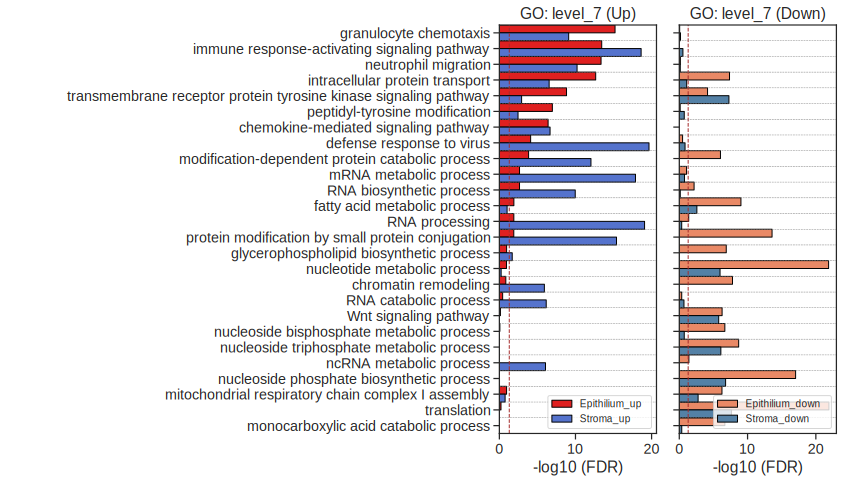

Bad pipe message: %s [b"\xcfI\x0f\x11\x0cX\x84M>\xcc\x94\xb7\xdf\xd0\x92\x10\xb8\xd1 i\xa9\x97gF\xa0KS\xedi\xfb\xb7\xb8A\xc6?K\xef\x9e\xa6\x80\xbaP\xb5\xf4\xa2t\xce7\x9b\xad[\x00$\x13\x02\x13\x03\x13\x01\xc0,\xc00\xc0+\xc0/\xcc\xa9\xcc\xa8\xc0$\xc0(\xc0#\xc0'\x00\x9f\x00\x9e\x00k\x00g\x00\xff\x01\x00\x00\x8b\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00*\x00(\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06\x01\x03\x03\x03\x01\x03\x02\x04\x02\x05\x02\x06\x02\x00+\x00\x05\x04\x03\x04\x03\x03\x00-\x00\x02\x01\x01\x003\x00&\x00$\x00\x1d\x00 \xe3+/K<|\x94\xb8\x14\xdf\xcc\xd4o\x03\xe9\xc7$"]


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sns.set(font_scale=1.3)
sns.set_style("ticks")

all_sig_res = []
groups = ['Epithilium_up','Epithilium_down', 'Stroma_up', 'Stroma_down']
# Read and process data for each group
for group in groups:
    if group == 'Epithilium_up':
        goea_enrich = pd.read_csv('GO/GO_enrich_sig_results_ep_wt_up_PAO1.csv')
    elif group == 'Epithilium_down':
        goea_enrich = pd.read_csv('GO/GO_enrich_sig_results_ep_wt_down_PAO1.csv')
    elif group == 'Stroma_up':
        goea_enrich = pd.read_csv('GO/GO_enrich_sig_results_str_wt_up_PAO1.csv')
    elif group == 'Stroma_down':
        goea_enrich = pd.read_csv('GO/GO_enrich_sig_results_str_wt_down_PAO1.csv')
    goea_enrich['Group'] = group
    all_sig_res.append(goea_enrich)

all_sig_res = pd.concat(all_sig_res)

# Filter out results with depth <= 2
go_level = 7
all_sig_res = all_sig_res[all_sig_res.depth == go_level]

# Select Biological Process (BP) results
sig_GO = all_sig_res[all_sig_res.GO_types == 'BP']
sig_GO['-log10(p_fdr_bh)'] = -np.log10(sig_GO['p_fdr_bh'])

# Select top pathways based on FDR threshold
top_pathways = set(all_sig_res[all_sig_res.p_fdr_bh < 1e-6].GO.tolist())

# Filter sig_GO DataFrame with top_pathways
sig_GO = sig_GO[sig_GO.GO.isin(top_pathways)]
sig_GO = sig_GO[~sig_GO.name.str.contains('regulation|radiation|regulating')]

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7), sharey=True)

# Function to plot each group
def plot_group(ax, groups_to_plot,cmap):
    plot_data = sig_GO[sig_GO['Group'].isin(groups_to_plot)]
    sns.barplot(
        x="-log10(p_fdr_bh)",
        y="name",
        hue="Group",
        data=plot_data,
        palette=cmap,
        hue_order=groups_to_plot,
        width=1,
        ax=ax,
        linewidth=1,
        edgecolor='black'
    )
    ax.axvline(-np.log10(0.05), c="brown", lw=1, ls="--")
    ax.set_xlabel("-log10 (FDR)")
    ax.set_ylabel("")
    for i in range(len(plot_data.name.unique()) - 1):
        ax.axhline(i + 0.5, c="gray", lw=0.5, ls="--")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, groups_to_plot, loc='lower right', fontsize = 10)

# Plot for Epithilium_up and Stroma_up
plot_group(axes[0], ['Epithilium_up', 'Stroma_up'], ['red','royalblue'])
axes[0].set_title('GO: level_' + str(go_level) + ' (Up)')

# Plot for Epithilium_down and Stroma_down
plot_group(axes[1], ['Epithilium_down', 'Stroma_down'], ['coral','steelblue'])
axes[1].set_title('GO: level_' + str(go_level) + ' (Down)', )

plt.tight_layout()
plt.show()

sig_GO.to_csv('GO/GO_enrich_sig_results_epi_str_wt_up_down_PAO1.csv', index=False)